In [1]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
from keras.models import Sequential, load_model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu, "\n")
else:
  print("No GPU device found")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') 



In [3]:
!nvidia-smi

Sat Jun  3 15:06:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| 46%   51C    P8              12W / 200W |    556MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
#Combined Dataset

df = pd.read_csv('H:/Datasets/cic-ids-2018/ddos-loic-udp_hoic_21-02-2018.csv', low_memory=True)
#df = df.append(pd.read_csv('H:/Datasets/cic-ids-2018/dos-goldeneye-slowloris_15-02-2018.csv', low_memory=True))
#df = df.append(pd.read_csv('H:/Datasets/cic-ids-2018/dos-slowhttp-hulk_16-02-2018.csv', low_memory=True))
#df = df.append(pd.read_csv('H:/Datasets/cic-ids-2018/bot_02-03-2018.csv', low_memory=True))

df = df.rename(columns={'label': 'Label'})
#df.drop(df.loc[df['Label'] == 'Label'].index, inplace=True)

In [5]:
df.describe()

,dst_port,protocol,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,...,fwd_act_data_pkts,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,...,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.958764e+04,6.037952e+00,3.990401e+05,1.968099e+02,1.309663e+00,6.563581e+03,2.486527e+02,3.666938e+02,2.549479e-01,7.977144e+01,...,1.941294e+02,1.995892e+01,7.521672e+03,2.589427e+03,1.003609e+04,5.446253e+03,3.140514e+04,1.602645e+04,5.723070e+04,1.633481e+04
std,2.719338e+04,6.495848e-01,6.630337e+06,4.899047e+03,1.477423e+00,1.567596e+05,3.257857e+02,4.226960e+02,8.978105e+00,8.511139e+01,...,4.899113e+03,7.395666e-01,2.033449e+05,1.034448e+05,2.825239e+05,1.568789e+05,8.419967e+05,4.340229e+05,1.421182e+06,5.894628e+05
min,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+01,6.000000e+00,1.408000e+03,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,6.000000e+00,4.720000e+03,3.000000e+00,0.000000e+00,2.470000e+02,0.000000e+00,3.200000e+01,0.000000e+00,3.200000e+01,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.355300e+04,6.000000e+00,1.464900e+04,5.000000e+00,2.000000e+00,9.350000e+02,3.160000e+02,9.350000e+02,0.000000e+00,1.870000e+02,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553400e+04,1.700000e+01,1.200000e+08,3.096290e+05,1.240000e+02,9.908128e+06,9.121000e+03,2.224000e+03,9.760000e+02,9.760000e+02,...,3.096280e+05,4.400000e+01,2.000000e+07,1.620000e+07,2.800000e+07,2.000000e+07,1.060000e+08,5.030000e+07,1.060000e+08,1.060000e+08


In [6]:
df.head()

,dst_port,protocol,timestamp,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,...,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,Label
0,80,6,21/02/2018 08:33:25,37953,5,3,135,127,135,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,500,17,21/02/2018 08:33:06,117573474,3,0,1500,0,500,500,...,8,0.0,0.0,0,0,58800000.0,23800000.0,75600000,42000000,Benign
2,500,17,21/02/2018 08:33:06,117573474,3,0,1500,0,500,500,...,8,0.0,0.0,0,0,58800000.0,23800000.0,75600000,42000000,Benign
3,500,17,21/02/2018 08:33:11,99743998,5,0,2500,0,500,500,...,8,4000290.0,0.0,4000290,4000290,31900000.0,37900000.0,75600000,7200397,Benign
4,500,17,21/02/2018 08:33:11,99743999,5,0,2500,0,500,500,...,8,4000286.0,0.0,4000286,4000286,31900000.0,37900000.0,75600000,7200399,Benign


In [7]:
df["Label"].value_counts()

DDOS attack-HOIC        686012
Benign                  360833
DDOS attack-LOIC-UDP      1730
Name: Label, dtype: int64

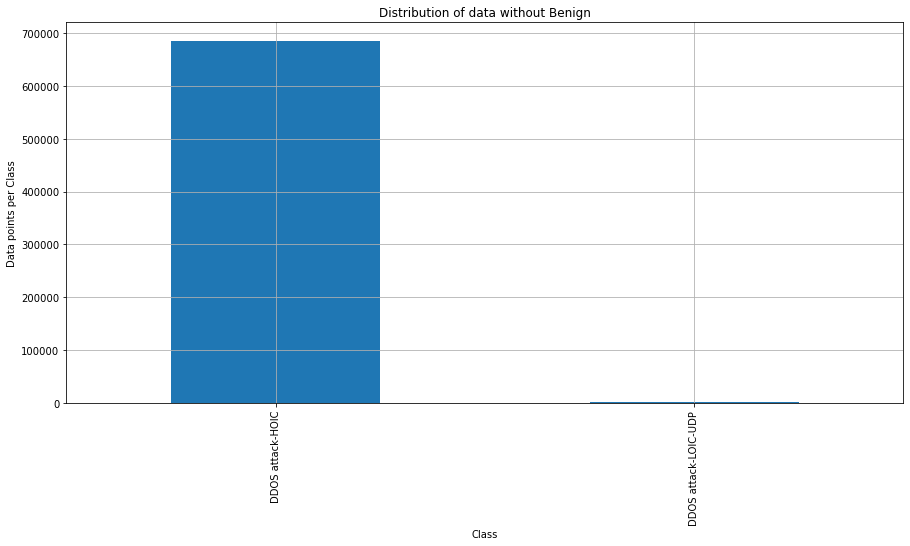

In [8]:
# Exploratory data analysis
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

plt.figure(figsize=(15,7))
class_distribution = df[df["Label"] != "Benign"]["Label"].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of data without Benign')
plt.grid()
plt.show()

In [9]:
metadata = ['fl_dur' #Flow duration
,'tot_fw_pk' #Total packets in the forward direction
,'tot_bw_pk' #Total packets in the backward direction
,'tot_l_fw_pkt' #Total size of packet in forward direction
,'fw_pkt_l_max' #Maximum size of packet in forward direction
,'fw_pkt_l_min' #Minimum size of packet in forward direction
,'fw_pkt_l_avg' #Average size of packet in forward direction
,'fw_pkt_l_std' #Standard deviation size of packet in forward direction
,'Bw_pkt_l_max' #Maximum size of packet in backward direction
,'Bw_pkt_l_min' #Minimum size of packet in backward direction
,'Bw_pkt_l_avg' #Mean size of packet in backward direction
,'Bw_pkt_l_std' #Standard deviation size of packet in backward direction
,'fl_byt_s' #flow byte rate that is number of packets transferred per second
,'fl_pkt_s' #flow packets rate that is number of packets transferred per second
,'fl_iat_avg' #Average time between two flows
,'fl_iat_std' #Standard deviation time two flows
,'fl_iat_max' #Maximum time between two flows
,'fl_iat_min' #Minimum time between two flows
,'fw_iat_tot' #Total time between two packets sent in the forward direction
,'fw_iat_avg' #Mean time between two packets sent in the forward direction
,'fw_iat_std' #Standard deviation time between two packets sent in the forward direction
,'fw_iat_max' #Maximum time between two packets sent in the forward direction
,'fw_iat_min' #Minimum time between two packets sent in the forward direction
,'bw_iat_tot' #Total time between two packets sent in the backward direction
,'bw_iat_avg' #Mean time between two packets sent in the backward direction
,'bw_iat_std' #Standard deviation time between two packets sent in the backward direction
,'bw_iat_max' #Maximum time between two packets sent in the backward direction
,'bw_iat_min' #Minimum time between two packets sent in the backward direction
,'fw_psh_flag' #Number of times the PSH flag was set in packets travelling in the forward direction (0 for UDP)
,'bw_psh_flag' #Number of times the PSH flag was set in packets travelling in the backward direction (0 for UDP)
,'fw_urg_flag' #Number of times the URG flag was set in packets travelling in the forward direction (0 for UDP)
,'bw_urg_flag' #Number of times the URG flag was set in packets travelling in the backward direction (0 for UDP)
,'fw_hdr_len' #Total bytes used for headers in the forward direction
,'bw_hdr_len' #Total bytes used for headers in the forward direction
,'fw_pkt_s' #Number of forward packets per second
,'bw_pkt_s' #Number of backward packets per second
,'pkt_len_min' #Minimum length of a flow
,'pkt_len_max' #Maximum length of a flow
,'pkt_len_avg' #Mean length of a flow
,'pkt_len_std' #Standard deviation length of a flow
,'pkt_len_va' #Minimum inter-arrival time of packet
,'fin_cnt' #Number of packets with FIN
,'syn_cnt' #Number of packets with SYN
,'rst_cnt' #Number of packets with RST
,'pst_cnt' #Number of packets with PUSH
,'ack_cnt' #Number of packets with ACK
,'urg_cnt' #Number of packets with URG
,'cwe_cnt' #Number of packets with CWE
,'ece_cnt' #Number of packets with ECE
,'down_up_ratio' #Download and upload ratio
,'pkt_size_avg' #Average size of packet
,'fw_seg_avg' #Average size observed in the forward direction
,'bw_seg_avg' #Average size observed in the backward direction
,'fw_byt_blk_avg' #Average number of bytes bulk rate in the forward direction
,'fw_pkt_blk_avg' #Average number of packets bulk rate in the forward direction
,'fw_blk_rate_avg' #Average number of bulk rate in the forward direction
,'bw_byt_blk_avg' #Average number of bytes bulk rate in the backward direction
,'bw_pkt_blk_avg' #Average number of packets bulk rate in the backward direction
,'bw_blk_rate_avg' #Average number of bulk rate in the backward direction
,'subfl_fw_pk' #The average number of packets in a sub flow in the forward direction
,'subfl_fw_byt' #The average number of bytes in a sub flow in the forward direction
,'subfl_bw_pkt' #The average number of packets in a sub flow in the backward direction
,'subfl_bw_byt' #The average number of bytes in a sub flow in the backward direction
,'fw_win_byt' #Number of bytes sent in initial window in the forward direction
,'bw_win_byt' ## of bytes sent in initial window in the backward direction
,'Fw_act_pkt' ## of packets with at least 1 byte of TCP data payload in the forward direction
,'fw_seg_min' #Minimum segment size observed in the forward direction
,'atv_avg' #Mean time a flow was active before becoming idle
,'atv_std' #Standard deviation time a flow was active before becoming idle
,'atv_max' #Maximum time a flow was active before becoming idle
,'atv_min' #Minimum time a flow was active before becoming idle
,'idl_avg' #Mean time a flow was idle before becoming active
,'idl_std' #Standard deviation time a flow was idle before becoming active
,'idl_max' #Maximum time a flow was idle before becoming active
,'idl_min' #Minimum time a flow was idle before becoming active
]

In [10]:
#features = df.columns

In [11]:
features = ['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

In [12]:
# Remove columns with only values of 0
useless_columns = ['dst_port', 'protocol', 'timestamp']
df.drop(labels=useless_columns, axis='columns', inplace=True)
print('After dropping some columns: \n\t there are {} columns and {} rows'.format(len(df.columns), len(df)))

features = df.columns

After dropping some columns: 
	 there are 77 columns and 1048575 rows


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


#drop na values and reset index
data_clean = df.dropna().reset_index()

# label encoding
labelencoder = LabelEncoder()
data_clean['Label'] = labelencoder.fit_transform(data_clean['Label'])

data_clean['Label'].value_counts()

data_np = data_clean.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

#del df

X = data_np[:, 0:76]

enc = OneHotEncoder()

Y = enc.fit_transform(data_np[:,77:]).toarray()

In [14]:
data_clean.shape

(1048575, 78)

In [15]:
data_clean.columns

Index(['index', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts',
       'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
       'fwd_seg_size_avg', 'bwd_se

In [16]:
data_clean.head()

,index,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,...,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,Label
0,0,37953,5,3,135,127,135,0,27.0,60.373835,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
1,1,117573474,3,0,1500,0,500,500,500.0,0.000000,...,8,0.0,0.0,0,0,58800000.0,23800000.0,75600000,42000000,0
2,2,117573474,3,0,1500,0,500,500,500.0,0.000000,...,8,0.0,0.0,0,0,58800000.0,23800000.0,75600000,42000000,0
3,3,99743998,5,0,2500,0,500,500,500.0,0.000000,...,8,4000290.0,0.0,4000290,4000290,31900000.0,37900000.0,75600000,7200397,0
4,4,99743999,5,0,2500,0,500,500,500.0,0.000000,...,8,4000286.0,0.0,4000286,4000286,31900000.0,37900000.0,75600000,7200399,0


In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2, shuffle=True)

_features = X.shape[1]
n_classes = Y.shape[1]

In [18]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(786431, 76)
(786431, 3)
(262144, 76)
(262144, 3)


In [19]:
print(X.shape)
print(Y.shape)

(1048575, 76)
(1048575, 3)


In [20]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import keras

from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Dropout
from sklearn import metrics

# DNN

In [21]:
model = Sequential()

model.add(Dense(64, input_dim=_features, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(n_classes, kernel_initializer='normal'))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary() 

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='BinaryCrossentropy', optimizer=opt, metrics=['accuracy'])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=3, min_lr=0.0001)
    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=30,
                              verbose=True, #callbacks=[reduce_lr, early_stop_callback],
                              validation_data=(X_test, Y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4928      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [22]:
#model.save('H:/Datasets/CIC-IDS2018/dnn_model.h5')

In [23]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

8192/8192 [==============================] - 7s 827us/step


In [24]:
pred.shape
y_test.shape

(262144,)

In [25]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[ 89827,      1,      0],
       [     0, 171853,      0],
       [     0,      0,    463]], dtype=int64)

In [ ]:
cf_matrix = confMat

labels = ['DDOS attack-HOIC','Beneig', 'DDOS attack-LOIC-UDP']

sn.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', xticklabels=labels, yticklabels=labels, cmap='Blues')

In [26]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

8192/8192 [==============================] - 7s 835us/step
Inference time: 9.04 seconds
Completed
Time taken: 0:00:22.880786
Validation score: 0.9999961853027344
Evaluation score: [0.0031947544775903225, 0.9999961853027344]
Recall score: 0.9999961853027344
Precision score: 0.9999961853249317
F1 Measure score: 0.999996185297667
ROC-AUC score: 0.9999962987187817


In [28]:
# Plot for training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [29]:
start_by_epoch = 1
epochs = range(start_by_epoch, len(loss_values) + 1)

In [ ]:
# Exploratory data analysis
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

plt.plot(epochs, acc[start_by_epoch-1:], label='Training accuracy')
plt.plot(epochs, val_acc[start_by_epoch-1:], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()
plt.clf()


#plt.subplot(212)

plt.plot(epochs, loss_values[start_by_epoch-1:], label='Training Loss')
plt.plot(epochs, val_loss_values[start_by_epoch-1:], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()
plt.clf()

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(-0.02,1.02)
plt.title('Training and Validation Rate')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.show()

In [ ]:
cm_df = pd.DataFrame(confMat)

labels = ['DDOS attack-HOIC','Beneig', 'DDOS attack-LOIC-UDP']

plt.figure(figsize=(20,15))
sn.set(font_scale=1.4)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 

# CNN

In [27]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, MaxPooling1D, Dropout, Reshape
from sklearn import metrics


X_train = X_train.reshape(X_train.shape[0], 76, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 76, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, padding="same", activation="relu", input_shape=(_features, 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Convolution1D(filters=256, kernel_size=6, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(n_classes, kernel_initializer='normal'))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary() 

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

early_stop_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=3, min_lr=0.0001)
    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=30,
                              verbose=True, #callbacks=[reduce_lr, early_stop_callback],
                              validation_data=(X_test, Y_test))  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 76, 128)           896       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 256)           196864    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 256)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 4864)              0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [28]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))

#model.save('H:/Datasets/CIC-IDS2018/cnn_model.h5')

8192/8192 [==============================] - 8s 914us/step
Best loss: 4.547473237814098e-13
Balanced Acc loss: 100.0


In [29]:
# Plot for training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [30]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

8192/8192 [==============================] - 8s 925us/step
Inference time: 9.91 seconds
Completed
Time taken: 0:00:24.762975
Validation score: 1.0
Evaluation score: [4.547473237814098e-13, 1.0]
Recall score: 1.0
Precision score: 1.0
F1 Measure score: 1.0
ROC-AUC score: 1.0


In [31]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

8192/8192 [==============================] - 8s 952us/step


In [32]:
pred.shape
y_test.shape

(262144,)

In [33]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[ 89828,      0,      0],
       [     0, 171853,      0],
       [     0,      0,    463]], dtype=int64)

In [ ]:
cf_matrix = confMat

labels = ['DDOS attack-HOIC','Beneig', 'DDOS attack-LOIC-UDP']

sn.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', xticklabels=labels, yticklabels=labels, cmap='Blues')

In [29]:
start_by_epoch = 1
epochs = range(start_by_epoch, len(loss_values) + 1)

In [ ]:
plt.plot(epochs, acc[start_by_epoch-1:], label='Training accuracy')
plt.plot(epochs, val_acc[start_by_epoch-1:], label='Validation accuracy')
plt.title('CNN: Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()
plt.clf()

In [ ]:
#plt.subplot(212)

plt.plot(epochs, loss_values[start_by_epoch-1:], label='Training Loss')
plt.plot(epochs, val_loss_values[start_by_epoch-1:], label='Validation Loss')
plt.title('CNN: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()
plt.clf()

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(-0.02,1.02)
plt.title('CNN: Training and Validation Rate')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.show()

In [ ]:
cm_df = pd.DataFrame(confMat)

labels = ['DDOS attack-HOIC','Beneig', 'DDOS attack-LOIC-UDP']

plt.figure(figsize=(20,15))
sn.set(font_scale=1.4)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 